# Budowa i optymalizacja modelu XGBoost  

W tej części raportu skoncentrujemy się na budowie modelu predykcyjnego z wykorzystaniem algorytmu **XGBoost**. Celem jest stworzenie modelu, który z jak najwyższą skutecznością będzie prognozował, czy dany klient zdecyduje się na subskrypcję lokaty terminowej.

Proces modelowania obejmuje kilka etapów:  

- **budowę modelu bazowego** z domyślnymi hiperparametrami,

- **walidację jakości modelu** przy użyciu odpowiednich metryk,
  
- **optymalizację hiperparametrów**,

- **analizę wpływu kodowania zmiennych kategorycznych** (dummy variables),
  
- **selekcję zmiennych** w oparciu o ich istotność,
  
- wybór najlepszego modelu (tzw. **modelu champion**)  
oraz **szczegółową analizę jego działania** na zbiorze treningowym i testowym.  

Celem tych działań jest nie tylko uzyskanie wysokiej jakości predykcji, ale także zrozumienie, które zmienne mają największy wpływ na podejmowanie decyzji przez klientów oraz jak stabilny i generalizujący jest końcowy model.   
## Metryki  

W celu kompleksowej oceny jakości zbudowanych modeli oraz identyfikacji najbardziej wpływowych zmiennych predykcyjnych, zastosujemy trzy metryki:  

1. **Współczynnik GINI**

Współczynnik GINI mierzy zdolność modelu do odróżniania klas (czyli jego moc dyskryminacyjną) oraz jest on bezpośrednio powiązany z miarą AUC. Wartość GINI w przedziale od 0 do 100 wskazuje, jak dobrze model różnicuje obserwacje pozytywne i negatywne. Wyższe wartości oznaczają lepszą jakość predykcji.  

2. **Gain (Feature Importance)**

Miara gain określa, jak bardzo dana zmienna przyczynia się do poprawy jakości podziału w drzewach decyzyjnych. W kontekście XGBoost, gain jest jedną z domyślnych miar ważności zmiennych i wskazuje, o ile średnio poprawia się funkcja celu po użyciu danej cechy w podziale drzewa. Zmienna z najwyższym gain uznawana jest za najbardziej istotną predykcyjnie w kontekście struktury modelu.  

3. **PI (Permutation Importance)**

Permutation importance to technika oceny wpływu zmiennych. Polega na losowym permutowaniu wartości jednej zmiennej w zbiorze danych i mierzeniu spadku jakości predykcji modelu. Jeśli permutacja danej zmiennej znacząco pogarsza wyniki modelu, oznacza to, że zmienna ta zawiera istotne informacje predykcyjne. Jest to bardziej obiektywna miara niż gain, ponieważ ocenia realny wpływ zmiennej na końcową jakość modelu, niezależnie od sposobu, w jaki model ją wykorzystał.  

In [1]:
#biblioteki
import pandas as pd
import xgboost as xgb
from sklearn.metrics import roc_auc_score, confusion_matrix, ConfusionMatrixDisplay, roc_curve, auc
import plotly.io as pio
pio.renderers.default='notebook'
include_plotlyjs=True
import plotly.offline as pyo
pyo.init_notebook_mode(connected=True)
import plotly.graph_objects as go
import numpy as np
from sklearn.inspection import permutation_importance
from skopt.space import Integer, Real
from skopt import BayesSearchCV
from skopt.space import Integer, Real
from skopt import BayesSearchCV

#przygotowanie danych 
dane=pd.read_csv("C:/Users/wojtk/OneDrive/Pulpit/studia/zastosowanie modelowania w bankowości/raport 2/dane_list2.csv",sep=';')
dane=dane.reset_index()
dane=dane.rename(columns={'index':'id'})
dic_y={'yes':1, 'no':0}
dane['y'] = dane['y'].replace(dic_y)
dane2=dane.copy()
dane2[[i for i in dane2.columns if i not in ['y','id']]]
from sklearn.preprocessing import LabelEncoder
encoder=LabelEncoder()
for col in dane2.select_dtypes(include='object').columns:
    dane2[col]=encoder.fit_transform(dane2[col])
from sklearn.model_selection import train_test_split
X_train,X_test,y_train, y_test = train_test_split(dane2[[i for i in dane2.columns if i not in ['y','id']]], dane2.y,test_size=0.2, random_state=39)

In [2]:
#funkcje używane w trakcie analizy

#miara gini 
def gini(true_val, predicted_val):
    return 2*roc_auc_score(true_val, predicted_val)-1

#przygotowanie tabeli do ułatwienia porównywania zbudowanych modeli  
pd.set_option('display.width', 1000)
pd.set_option('display.max_colwidth', None)

def model_summary(model, model_name, opis, df_train, df_test, train_y, test_y):
    gini_train=gini(true_val=train_y, predicted_val=model.predict_proba(df_train)[:,1])
    gini_test=gini(true_val=test_y, predicted_val=model.predict_proba(df_test)[:,1])
    l=df_train.shape[1]
    df_return=pd.DataFrame({
        "Nazwa modelu": [model_name],
        "Opis": [opis],
        "Liczba zmiennych": [l],
        "Gini TRAIN": [100*gini_train],
        "Gini TEST": [100*gini_test]
    })
    return df_return

#funkcja do rysowania wykresow dla miar 

def plot_miara(zmienne, miara, tytul, nazwax):
    sorted_idx = np.argsort(miara)
    sorted_zmienne = np.array(zmienne)[sorted_idx]
    sorted_miara = np.array(miara)[sorted_idx]
    
    df = pd.DataFrame({"Zmienne": sorted_zmienne, "Miara": sorted_miara})
    fig = go.Figure(go.Bar(x=df["Miara"], y=df["Zmienne"],orientation='h'))
    fig.update_layout(title=tytul, xaxis_title=nazwax, yaxis_title="Zmienne",
                     height=800,template='ggplot2')  
    pio.show(fig)



## Model na domyślnych hiperparametrach  

Pierwszym krokiem w procesie modelowania jest stworzenie modelu bazowego, opartego na domyślnych ustawieniach hiperparametrów algorytmu XGBoost. Model ten stanowi punkt odniesienia dla dalszych analiz oraz procesów optymalizacyjnych i pozwala ocenić, jaką jakość predykcji można uzyskać bez dodatkowego *strojenia*.

In [3]:
model1=xgb.XGBClassifier()
model1.fit(X_train, y_train)

wyniki=model_summary(model1, 'model 1.','model na domyślnych hiperparametrach', X_train, X_test, y_train, y_test)
wyniki

,Nazwa modelu,Opis,Liczba zmiennych,Gini TRAIN,Gini TEST
0,model 1.,model na domyślnych hiperparametrach,16,96.410087,85.406136


### GINI  

Model bazowy osiągnął wysoką wartość współczynnika GINI zarówno na zbiorze treningowym, jak i testowym. Wysoka wartość GINI na zbiorze TRAIN świadczy o tym, że model bardzo dobrze dopasował się do danych treningowych. Z kolei wartość na zbiorze TEST pozostaje nadal wysoka, co sugeruje, że model ma dobrą zdolność generalizacji. Różnica pomiędzy GINI TRAIN a GINI TEST (ok. 11 punktów procentowych) jest zauważalna i dość duża, co może świadczyć o nadmiernym przeuczeniu modelu na danych treningowych.  

In [4]:
zmienne1=dane2[[i for i in dane2.columns if i not in ['y','id']]].columns

fi1=model1.feature_importances_
plot_miara(zmienne1, fi1, 'Feature Importance', 'GAIN')

pi_results1=permutation_importance(model1, X_train, y_train, n_repeats=10, random_state=20)
pi1=pi_results1.importances_mean
plot_miara(zmienne1, pi1, 'Permutation Importance', 'PI')

### GAIN I PI  

Zwróćmy uwagę na kilka szczególnych przypadków/zmiennych:  

- Zmienna *poutcome*: Bardzo wysoka wartość GAIN sugeruje, że model intensywnie z niej korzysta, ale niski PI wskazuje, że jej wpływ na jakość predykcji nie jest tak duży. Możliwa nadinterpretacja przez model – potencjalne ryzyko overfittingu. Zmienne o podobnej charakterystyce: *loan*, *housing*.

- Zmienna *duration*: Zarówno GAIN, jak i PI są wysokie — to mocna, stabilna i istotna cecha, która rzeczywiście wpływa na wynik modelu. Zmienne o podobnej charakterystyce: *month*, *contact*

- Zmienna *day*: Wysokie PI oraz niskie GAIN sugerują, że model wykorzystuje je tylko umiarkowanie, ale ich PI sugeruje, że mają realny wpływ na predykcje. Zmienna o podobnej charakterystyce: *balance*.

Podsumowując, analiza pokazuje, że nie wszystkie zmienne wykorzystywane intensywnie przez model mają rzeczywisty wpływ na jego trafność. Dzięki temu możemy lepiej zrozumieć, które cechy są naprawdę wartościowe, a które mogą prowadzić do przeuczenia.

## Model na domyślnych hiperparametrach ze zmiennymi dummy  

W tej części budujemy model na tych samych domyślnych parametrach co model 1., jednak z wykorzystaniem zmiennych zakodowanych w postaci **dummy** (0,1).  

Zamiana zmiennych kategorycznych na kodowanie zero-jedynkowe (tzw. one-hot encoding) pozwala modelowi lepiej uchwycić nieliniowe zależności i unika założeń o porządku czy odległości między kategoriami. Każda kategoria zostaje przekształcona w oddzielną binarną kolumnę, co zwiększa wymiarowość danych, ale może poprawić skuteczność modelu.

In [5]:
dane3=pd.get_dummies(dane[[i for i in dane.columns if i != 'y' and i != 'id']])
dane3=dane3.drop(columns=['job_admin.','marital_divorced','education_primary','default_no','housing_no','loan_no',
                          'contact_cellular','month_apr','poutcome_failure'])
X_train_d=dane3.iloc[X_train.index, :].copy()
X_test_d=dane3.iloc[X_test.index, :].copy()

model2=xgb.XGBClassifier()
model2.fit(X_train_d, y_train)

wyniki=pd.concat([wyniki, model_summary(model2, 'model 2.','model na domyślnych hiperparametrach ze zmiennymi dummy', X_train_d, X_test_d, y_train, y_test)])
wyniki

,Nazwa modelu,Opis,Liczba zmiennych,Gini TRAIN,Gini TEST
0,model 1.,model na domyślnych hiperparametrach,16,96.410087,85.406136
0,model 2.,model na domyślnych hiperparametrach ze zmiennymi dummy,42,95.910002,85.662752


### GINI  

Liczba zmiennych wzrosła znacząco, co powoduje większość złożonośc modelu, czyli również większą złożonośc obliczeniową - może się to przełożyć na czas obsługi modelu.  

Model 2. uzyskał lepszy wynik GINI na zbiorze testowym, przy czym wynik dla zbiory treningowego lekko spadł - jednak wciąż jest na bardzo wysokim poziomie.  

Podsumowując wynik dla zbioru treningowego jest nieco mniejszy, jednka różnica między GINI TRAIN i GINI TEST jest nieco mniejsza, niż dla modelu 1., więc możemy powiedzieć, że wprowadzenie zmiennych dummy nieznacznie poprawiło model. 

In [6]:
zmienne2 = dane3.columns

fi2=model2.feature_importances_
plot_miara(zmienne2, fi2, 'Feature Importance', 'GAIN')

pi_results2=permutation_importance(model2, X_train_d, y_train, n_repeats=10, random_state=20)
pi2=pi_results2.importances_mean
plot_miara(zmienne2, pi2, 'Permutation Importance', 'PI')

### GAIN I PI  

- Zmienna *poutcome_success*: zdecydowanie najwyższy GAIN (0.207) oraz umiarkowane PI– sugeruje, żmodel często ją  wykorzystuje i ma realny wpływ. Zmienne o podobmej charakterystyce: *month_jun*, *contact_unknown*, *duration* oraz *housing_yes*.

- Wiele zmiennych związanych z *job*, *marital*, czy *education* ma bardzo niskie PI, mimo niezerowych wartości GAIN. To może sugerować, że są mało istotne dla predykcji, ale model je mimo wszystko częściowo uwzględnia.

## Model z optymalizowanymi hipermarametrami dla standardowego zbioru treningowego  

W tej części przechodzimy do budowy modelu, który będzie bardziej dopasowany do danych poprzez strojenie hiperparametrów. Zamiast korzystać z domyślnych ustawień, wykorzystamy metodę optymalizacji hiperparametrów opartą na BayesSearchCV – jest to podejście bayesowskie, które efektywniej przeszukuje przestrzeń parametrów niż klasyczny GridSearchCV. Metoda ta działa iteracyjnie – na podstawie wyników poprzednich prób przewiduje, które kombinacje parametrów warto zbadać w kolejnych krokach, co pozwala szybciej znaleźć dobrze dopasowane ustawienia przy mniejszej liczbie prób niż w przypadku losowego czy siatkowego przeszukiwania.

In [7]:
model3=xgb.XGBClassifier()

param_space={
    'n_estimators': Integer(50,200),
    'max_depth': Integer(3,10),
    'min_child_weight': Integer(1,200),
    'learning_rate':Real(0.01, 0.3, prior='log-uniform'),
    'subsample': Real(0.6, 1.0),
    'colsample_bytree': Real(0.6,1.0),
    'gamma': Real(1e-4,10,prior='log-uniform'),
    'reg_lambda': Real(1e-4,10,prior='log-uniform'),
    'reg_alpha': Real(1e-4,10,prior='log-uniform')
}

grid_search1=BayesSearchCV(
    estimator=model3,
    search_spaces=param_space,
    scoring='neg_mean_squared_error',
    n_iter=50,
    cv=3,
    verbose=3,
    random_state=42
)
import contextlib
import sys
import os

# tymczasowe wyciszenie outputu
with open(os.devnull, 'w') as f, contextlib.redirect_stdout(f), contextlib.redirect_stderr(f):
    grid_search1.fit(X_train, y_train)

In [8]:
wyniki=pd.concat([wyniki, model_summary(grid_search1, 'model 3.','Model z optymalizowanymi hipermarametrami dla standardowego zbioru treningowego', X_train, X_test, y_train, y_test)])
wyniki

,Nazwa modelu,Opis,Liczba zmiennych,Gini TRAIN,Gini TEST
0,model 1.,model na domyślnych hiperparametrach,16,96.410087,85.406136
0,model 2.,model na domyślnych hiperparametrach ze zmiennymi dummy,42,95.910002,85.662752
0,model 3.,Model z optymalizowanymi hipermarametrami dla standardowego zbioru treningowego,16,92.777269,86.411074


### GINI  

Model 3 ma najlepszą jakość predykcji na zbiorze testowym, mimo że ma mniejszy Gini na treningowym to oznacza, że lepiej generalizuje na nowych danych – prawdopodobnie nie przeuczył się jak model 1.  

Model 3, dzięki optymalizacji hiperparametrów, osiągnął najlepszy balans między dopasowaniem a generalizacją.

In [10]:
fi3=grid_search1.best_estimator_.feature_importances_
plot_miara(zmienne1, fi3, 'Feature Importance', 'GAIN')

pi_results3=permutation_importance(grid_search1, X_train, y_train, n_repeats=10, random_state=20)
pi3=pi_results3.importances_mean
plot_miara(zmienne1, pi3, 'Permutation Importance', 'PI')

### GAIN I PI  

- Zmienna *poutcome*: najwyższy GAIN, ale stosunkowo niskie PI sugeruje, że model intensywnie jej używa, ale jej wpływ na trafność predykcji nie jest proporcjonalnie wysoki - możliwe przeuczenie.

- Zmienna *duration*: bardzo wysoki GAIN  i najwyższy PI sugeruje, że jest to najmocniejsza i najbardziej stabilna cecha modelu.

- Zmienne *month*, *pdays* oraz *contact*: umiarkowanie duże GAIN i Pi sugeruje, że te zmienne dobrze wspierają predykcję.

- Zmienna *loan*: wysokie GAIN oraz niskie PI wskazują na to, że model często używa tej zmiennej, jednak nie jest ona znacząco istotna.

- Zmienne *default*, *marital* oraz *job*: niskie GAIN oraz PI - możliwi kandydaci do usunięcia w kontekście budownia następnych modeli.
  

## Model z optymalizowanymi hiperparametrami (użycie tych samych co dla model 3.) dla zmiennych dummy  

W tej części zastosujemy wcześniej wybrane, optymalne hiperparametry (z modelu 3.) do modelu trenowanego na danych z zakodowanymi zmiennymi typu dummy. Celem jest sprawdzenie, czy zwiększona liczba zmiennych (uzyskana przez kodowanie one-hot) w połączeniu z dobrze dobranymi hiperparametrami pozwoli uzyskać jeszcze lepsze dopasowanie i skuteczność predykcji na zbiorze testowym.

In [11]:
model4=xgb.XGBClassifier()
grid_search2=BayesSearchCV(
    estimator=model4,
    search_spaces=param_space,
    scoring='neg_mean_squared_error',
    n_iter=50,
    cv=3,
    verbose=3,
    random_state=42
)

with open(os.devnull, 'w') as g, contextlib.redirect_stdout(g), contextlib.redirect_stderr(g):
    grid_search2.fit(X_train_d, y_train)


In [12]:
wyniki=pd.concat([wyniki, model_summary(grid_search2, 'model 4.','Model z optymalizowanymi hiperparametrami (użycie tych samych co dla model 3.) dla zmiennych dummy ', X_train_d, X_test_d, y_train, y_test)])
wyniki

,Nazwa modelu,Opis,Liczba zmiennych,Gini TRAIN,Gini TEST
0,model 1.,model na domyślnych hiperparametrach,16,96.410087,85.406136
0,model 2.,model na domyślnych hiperparametrach ze zmiennymi dummy,42,95.910002,85.662752
0,model 3.,Model z optymalizowanymi hipermarametrami dla standardowego zbioru treningowego,16,92.777269,86.411074
0,model 4.,Model z optymalizowanymi hiperparametrami (użycie tych samych co dla model 3.) dla zmiennych dummy,42,90.600459,85.904890


### GINI  

Najnższe Gini na zbiorze treningowym, przy czym wciąż na bardzo wysokim poziomie, pokazuje, że model 4 jeszcze mocniej unika przeuczenia niż pozostałe – jest „ostrożniejszy” w dopasowywaniu się do danych. Gini na zbiorze testowym, jest nieco gorsze niż dla modelu 3., jednak bardzo bliskie. Niski wyniki Gini TRAIN powoduje, że różnica między Gini TRAIN a Gini TEST jest najmniejsza ze wszystkich modeli. Co oznacza, że model jest najlepszy pod względem generalizacji.  

In [14]:
fi4=grid_search2.best_estimator_.feature_importances_
plot_miara(zmienne2, fi4, 'Feature Importance', 'GAIN')

pi_results4=permutation_importance(grid_search2, X_train_d, y_train, n_repeats=10, random_state=20)
pi4=pi_results4.importances_mean
plot_miara(zmienne2, pi4, 'Permutation Importance', 'PI')


### GAIN I PI  

- Zmienne, których model nie docenia (z wyższym PI i niskim GAIN): *day*, *balance* oraz niektóre stowarzyszone ze zmienna *month*.

- Potencjalne żródło przeuczenia (wysoki GAIN i niskie PI): *poutcome_unknown*, *job_blue-collar* oraz *job_student*.

- Zmienne nieistotne pod względem zarowno GAIN, jak i PI: m.in. *job_unknown*, *education_secondary* oraz *job_unemployed*. Zmienna *job_unknown* uzyskała ujemną wartość PI, co może sugerować, że ma negatywny wpływ na predykcję.  

## WYBÓR CHAMPIONA I UZASADNIENIE

In [15]:
wyniki

,Nazwa modelu,Opis,Liczba zmiennych,Gini TRAIN,Gini TEST
0,model 1.,model na domyślnych hiperparametrach,16,96.410087,85.406136
0,model 2.,model na domyślnych hiperparametrach ze zmiennymi dummy,42,95.910002,85.662752
0,model 3.,Model z optymalizowanymi hipermarametrami dla standardowego zbioru treningowego,16,92.777269,86.411074
0,model 4.,Model z optymalizowanymi hiperparametrami (użycie tych samych co dla model 3.) dla zmiennych dummy,42,90.600459,85.904890


Po przeanalizowaniu wyników czterech modeli, model 4 – z optymalizowanymi hiperparametrami i użyciem zmiennych dummy – wybieramy jako model-champion. Choć model 3 osiągnął najlepszy wynik na zbiorze treningowym, model 4 wykazuje najlepszą zdolność do generalizacji, co czyni go bardziej odpornym na przeuczenie.

Wynik na zbiorze testowym w modelu 4 (85.90) jest lepszy niż w modelach 1 i 2, co świadczy o większej trafności w predykcjach na nowych, niewidzianych wcześniej danych.

Mimo użycia większej liczby zmiennych, model 4 zachowuje wysoką jakość predykcji, co jest kluczowe w kontekście jego ogólnej efektywności.

Ponadto, niższe Gini na zbiorze treningowym (90.60) wskazuje, że model lepiej radzi sobie z unikaniem przeuczenia i jest bardziej zrównoważony w swoim podejściu do danych.

Model 4 jest idealnym kandydatem do dalszej analizy i ewentualnego wdrożenia w praktyce, ponieważ charakteryzuje się dobrym kompromisem między jakością dopasowania a zdolnością do generalizacji.

## OPTYMALIZACJA ZMIENNYCH  

W tej części analizy przeprowadzimy proces optymalizacji zmiennych w celu znalezienia najbardziej efektywnego zestawu cech, które najlepiej wpływają na wydajność modelu. Celem tego kroku jest znalezienie optymalnej liczby zmiennych, które zapewnią najlepszą równowagę między jakością predykcji na zbiorze treningowym a zdolnością do generalizacji na danych testowych.  

Optymalizacja zmiennych jest ważnym krokiem w budowie modelu, ponieważ pozwala zmniejszyć ryzyko przeuczenia, co jest szczególnie ważne w przypadku złożonych modeli, jak XGBoost jednocześnie umożliwia ułatwienie interpretacji modelu — mniejsza liczba zmiennych oznacza, że model jest łatwiejszy do zrozumienia i może być bardziej przejrzysty w procesie analizy.

In [16]:
def gini_per_feat(model, df_train, train_y, df_test, test_y, print_df_results=False, params=None):
    df_ist=pd.DataFrame({'features': df_train.columns,
                        'Feature Importance': model.best_estimator_.feature_importances_}).sort_values('Feature Importance', ascending=False).reset_index(drop=True)
    df_ist['GINI Train']=0
    df_ist['GINI Test']=0
    feats=[]

    for i in range(0, df_train.shape[1]):
        feats.append(df_ist.loc[i, 'features'])

        if params is None:
            model_new=xgb.XGBClassifier()
        else:
            model_new=xgb.XGBClassifier(**params)
        model_new.fit(df_train[feats],train_y)

        gini_train=gini(true_val=train_y, predicted_val=model_new.predict_proba(df_train[feats])[:,1])
        gini_test=gini(true_val=test_y, predicted_val=model_new.predict_proba(df_test[feats])[:,1])
        df_ist.loc[i, 'GINI Train']=gini_train
        df_ist.loc[i, 'GINI Test']=gini_test

    if print_df_results:
        display(df_ist)
    fig=go.Figure()
    fig.add_trace(go.Scatter(x=df_ist.features, y=df_ist['GINI Train'],
                            mode='lines+markers',
                            name='TRAIN'))
    fig.add_trace(go.Scatter(x=df_ist.features, y=df_ist['GINI Test'],
                            mode='lines+markers',
                            name='TEST'))
    fig.update_layout(height=800,template='ggplot2')
    fig.show()
    #return df_ist

gini_per_feat(grid_search2, X_train_d, y_train, X_test_d, y_test, params=grid_search2.best_params_)

Po przeanalizowaniu wyników zauważyliśmy, że poziomy Gini dla zmiennych powyżej 28-tej są niemal identyczne zarówna na zbiorze treningowym jaki i testowym, co sugeruje, że te zmienne mają minimalny wpływ na model. W związku z tym możemy odrzuć mniej istotne zmienne, zachowując jedynie te 28 zmiennych, które wykazują istotne różnice i mają kluczowy wpływ na jakość predykcji. Dzięki temu uprościmy model, nie tracąc na jego efektywności, co prowadzi do stworzenia modelu *champion* z zoptymalizowaną liczbą zmiennych.

## Model champion z zoptymalizowaną liczbą zmiennych

In [17]:
df_ist=pd.DataFrame({'features': X_train_d.columns,
                        'Feature Importance': grid_search2.best_estimator_.feature_importances_}).sort_values('Feature Importance', ascending=False).reset_index(drop=True)

top=df_ist['features'].head(28).tolist()
best_p=grid_search2.best_params_
X_train_r=X_train_d[top].copy()
X_test_r=X_test_d[top].copy()

model5=xgb.XGBClassifier(**best_p)
model5.fit(X_train_r, y_train)
wyniki=pd.concat([wyniki, model_summary(model5, 'model 5.','Model champion z zoptymalizowaną liczbą zmiennych ', X_train_r, X_test_r, y_train, y_test)])
wyniki

,Nazwa modelu,Opis,Liczba zmiennych,Gini TRAIN,Gini TEST
0,model 1.,model na domyślnych hiperparametrach,16,96.410087,85.406136
0,model 2.,model na domyślnych hiperparametrach ze zmiennymi dummy,42,95.910002,85.662752
0,model 3.,Model z optymalizowanymi hipermarametrami dla standardowego zbioru treningowego,16,92.777269,86.411074
0,model 4.,Model z optymalizowanymi hiperparametrami (użycie tych samych co dla model 3.) dla zmiennych dummy,42,90.600459,85.904890
0,model 5.,Model champion z zoptymalizowaną liczbą zmiennych,28,90.107038,86.233377


Model 5. można uznać za model champion, zarówno pod względem skuteczności predykcji, jak i zdolności do generalizacji.

Po pierwsze, osiąga on prawie najwyższy wynik Gini na zbiorze testowym, co oznacza, że model bardzo dobrze radzi sobie z przewidywaniem nieznanych danych. Jednocześnie poziom Gini na zbiorze treningowym pozostaje na bardzo dobrym poziomie, ale nie jest przesadnie wysoki względem testowego, co sugeruje, że model nie jest przeuczony.

Co istotne, model ten wykorzystuje zoptymalizowaną liczbę zmiennych (28) — są to cechy wybrane na podstawie ich istotności, co pozwoliło uprościć strukturę modelu bez straty jakości. Zmniejszenie liczby zmiennych ułatwia interpretację, przyspiesza obliczenia i może pozytywnie wpływać na stabilność modelu w zastosowaniach produkcyjnych.

W porównaniu do pozostałych modeli, które albo są bardziej rozbudowane (np. model 2. i 4. z 42 zmiennymi), albo mają wyższy poziom Gini na treningu, ale słabszy na teście (np. model 1.), model 5. oferuje najlepszy kompromis między złożonością a jakością predykcji.



## Analiza jakościowa wybranego modelu 

W tej części przeprowadzimy **analizę jakościową** wybranego modelu (model 5.) przy użyciu zaawansowanej metody wyjaśniania wyników predykcji, jaką jest **SHAP**. SHAP to technika, która umożliwia zrozumienie, jak poszczególne cechy (zmienne) wpływają na decyzje podejmowane przez model. Dzięki SHAP możemy obliczyć przyczynowy wpływ każdej zmiennej na wynik predykcji dla poszczególnych przypadków, co pozwala na lepsze zrozumienie, w jaki sposób model podejmuje swoje decyzje.

Wykresy SHAP są niezwykle pomocne, ponieważ:
- **Wskazują wpływ każdej zmiennej** – dla każdego punktu danych możemy zobaczyć, jak zmiany w danej zmiennej wpłynęły na wynik predykcji.
- **Umożliwiają interpretację modelu**, zwłaszcza w przypadku bardziej złożonych algorytmów, jak XGBoost, gdzie trudno jest w prosty sposób zrozumieć, które cechy mają największy wpływ na decyzje modelu.
- **Wykrywają potencjalne problemy** – takie jak nadmierne uzależnienie modelu od nieistotnych zmiennych, nieoczekiwane interakcje między zmiennymi czy błędne zależności, które mogą prowadzić do nieprawidłowych wniosków.

Aby uzyskać wiarygodną ocenę wydajności modelu, przeprowadzimy również **walidację krzyżową**. Walidacja krzyżowa to technika oceny, która pozwala na uzyskanie bardziej rzetelnej miary jakości modelu. Zamiast dzielić dane na jedną parę zbioru treningowego i testowego, walidacja krzyżowa dzieli dane na kilka podzbiorów, co pozwala na wielokrotne trenowanie i testowanie modelu. Dzięki temu zmniejszamy ryzyko przeuczenia i uzyskujemy bardziej stabilny i uniwersalnci modelu.

Podsumowując, poprzez wykorzystanie zarówno wykresów SHAP, jak i walidacji krzyżowej, będziemy w stanie dokładnie ocenić jakość modelu 5. oraz zrozumieć, które zmienne mają największy wpływ na jego decyzje oraz upewnić się, że model nie jest zbyt wrażliwy na konkretne dane.

 99%|===================| 35891/36168 [01:26<00:00]        

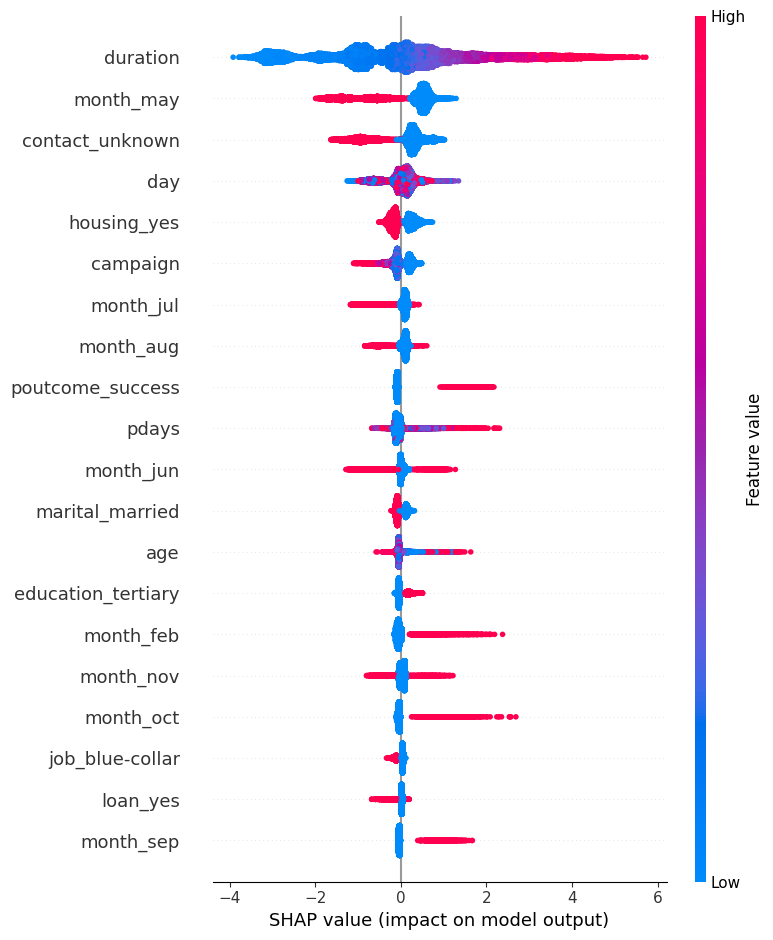

In [18]:
import shap
explainer=shap.TreeExplainer(model5, X_train_r)
shap_values=explainer.shap_values(X_train_r)
shap.summary_plot(shap_values, X_train_r)

- Największy wpływ na wynik modelu ma zmienna *duration* (czas trwania kontaktu) – dłuższy kontakt (kolor czerwony) wyraźnie zwiększa prawdopodobieństwo pozytywnej odpowiedzi.
  
- Znaczenie mają również zmienne związane z czasem kampanii (*month_may*, *month_jul*, *month_aug*, itd.) – ich wpływ może być zarówno dodatni, jak i ujemny, zależnie od miesiąca.
  
- Typ kontaktu (*contact_unknown*) i posiadanie kredytu hipotecznego (*housing_yes*) również mają istotny wpływ – nieznany typ kontaktu może działać negatywnie.
  
- Zmienna *campaign* przy wyższych wartościach wpływa raczej negatywnie.
 
Podsumowując: **model opiera się głównie na czasie trwania rozmowy oraz czasie i formie kontaktu z klientem.** Cechy socjodemograficzne (np. wiek, wykształcenie, zawód) mają mniejsze, ale nadal zauważalne znaczenie.

In [19]:
from sklearn.model_selection import StratifiedKFold, cross_val_score

skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
cv_scores = cross_val_score(model5, dane3[top], dane['y'], cv=skf, scoring='roc_auc')
gini_scores = 2 * cv_scores - 1
cv_r=pd.DataFrame({
    'Statystyka': ['Średnie GINI', "Odchylenie standardowe "],
    'Wartość':[gini_scores.mean(),gini_scores.std()]
})
cv_r

,Statystyka,Wartość
0,Średnie GINI,0.871767
1,Odchylenie standardowe,0.005877


Jako metrykę oceny wykorzystaliśmy **ROC AUC**, którą następnie przeliczono na współczynnik **GINI**, będący bardziej intuicyjną miarą jakości modelu w kontekście wcześniejszej analizy.  

Uzyskany średni współczynnik GINI na poziomie 0.872 wskazuje na **bardzo wysoką skuteczność predykcyjną modelu**, co oznacza, że klasyfikator dobrze rozróżnia przypadki pozytywne od negatywnych. W praktyce, im wyższy współczynnik GINI, tym większa zdolność modelu do trafnego przewidywania odpowiedzi klientów, a wynik powyżej 0.87 świadczy o solidnej jakości prognoz.

Dodatkowo, niskie odchylenie standardowe (0.0059) świadczy o **wysokiej stabilności modelu**, czyli o tym, że uzyskuje on bardzo zbliżone wyniki niezależnie od konkretnego podziału danych w ramach walidacji krzyżowej. Taka powtarzalność wyników jest szczególnie istotna w kontekście zastosowań biznesowych, ponieważ zmniejsza ryzyko niestabilnych prognoz w środowisku produkcyjnym.

Wnioski te potwierdzają, że model jest **nie tylko skuteczny, ale również odporny na losowe wahania w danych treningowych**, co czyni go **wiarygodnym i bezpiecznym wyborem do dalszego wykorzystania – zarówno analitycznego, jak i operacyjnego** (np. wdrożenia w systemach wspierających decyzje marketingowe).